In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from analysis import *

# Load data

In [2]:
f1 = open("r1-d0-result.txt")
raw1 = f1.read()
f1.close()

f2 = open("r1-d1-result.txt")
raw2 = f2.read()
f2.close()

f3 = open("r5-d0-result.txt")
raw3 = f3.read()
f3.close()

f4 = open("r5-d1-result.txt")
raw4 = f4.read()
f4.close()

f5 = open("r9-d0-result.txt")
raw5 = f5.read()
f5.close()

f6 = open("r9-d1-result.txt")
raw6 = f6.read()
f6.close()

In [3]:
Ttx = 1
Trx = 11
Tn = 1
    
def compute_histogram(r1,r2):
    
    Eb = 0
    Es = 0
    En = 0

    Eb,Es,En = computeEvents(r1,Ttx,Trx,Tn)

    display(Markdown('<span style="color: #af0000">'+"P(S) = %.6f"%(Trx*Es/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">'+"P(N) = %.6f"%(Tn*En/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">'+"P(B) = %.6f"%(Ttx*Eb/len(r1))+'</span>'))


    l1 = 1000*Eb / (len(r1))

    t = Trx/1000
    rt = l1*t

    print("r(B)(Events/s) = %.6f"%(l1))
    print("rt = %.6f"%(l1*t))

    Cb1 = countBroadcast(r2,r1,Trx,Ttx)

    hist1 = buildHistogram(Cb1,Trx,Ttx)

    print("Success probability= %.6f"%sum(hist1[1:]))
    return hist1,rt,Eb,Es,En

In [4]:
hist1,rt1,Eb1,Es1,En1 = compute_histogram(raw1,raw2)
print('---------------------')
hist2,rt2,Eb2,Es2,En2 = compute_histogram(raw3,raw4)
print('---------------------')
hist3,rt3,Eb3,Es3,En3 = compute_histogram(raw5,raw6)
print('---------------------')

<span style="color: #af0000">P(S) = 0.709650</span>

<span style="color: #00af00">P(N) = 0.193546</span>

<span style="color: #0000af">P(B) = 0.096804</span>

r(B)(Events/s) = 96.804000
rt = 1.064844
Success probability= 0.774270
---------------------


<span style="color: #af0000">P(S) = 0.938983</span>

<span style="color: #00af00">P(N) = 0.000001</span>

<span style="color: #0000af">P(B) = 0.061017</span>

r(B)(Events/s) = 61.016625
rt = 0.671183
Success probability= 0.488161
---------------------


<span style="color: #af0000">P(S) = 0.987193</span>

<span style="color: #00af00">P(N) = 0.000001</span>

<span style="color: #0000af">P(B) = 0.012807</span>

r(B)(Events/s) = 12.806812
rt = 0.140875
Success probability= 0.102617
---------------------


In [5]:
def check_distribution(hist,rt):
    rvd = poisson_dist(rt,len(hist1))
    print("RMSE Poisson= %.6f"%rmse(rvd,hist)) 
    geom_d = geom_dist(hist[0],len(hist))
    print("RMSE Geom= %.6f"%rmse(geom_d,hist))
    
check_distribution(hist1, rt1)
print('---------------------')
check_distribution(hist2, rt2)
print('---------------------')
check_distribution(hist3, rt3)

RMSE Poisson= 0.049947
RMSE Geom= 0.087671
---------------------
RMSE Poisson= 0.004648
RMSE Geom= 0.024693
---------------------
RMSE Poisson= 0.012256
RMSE Geom= 0.004588


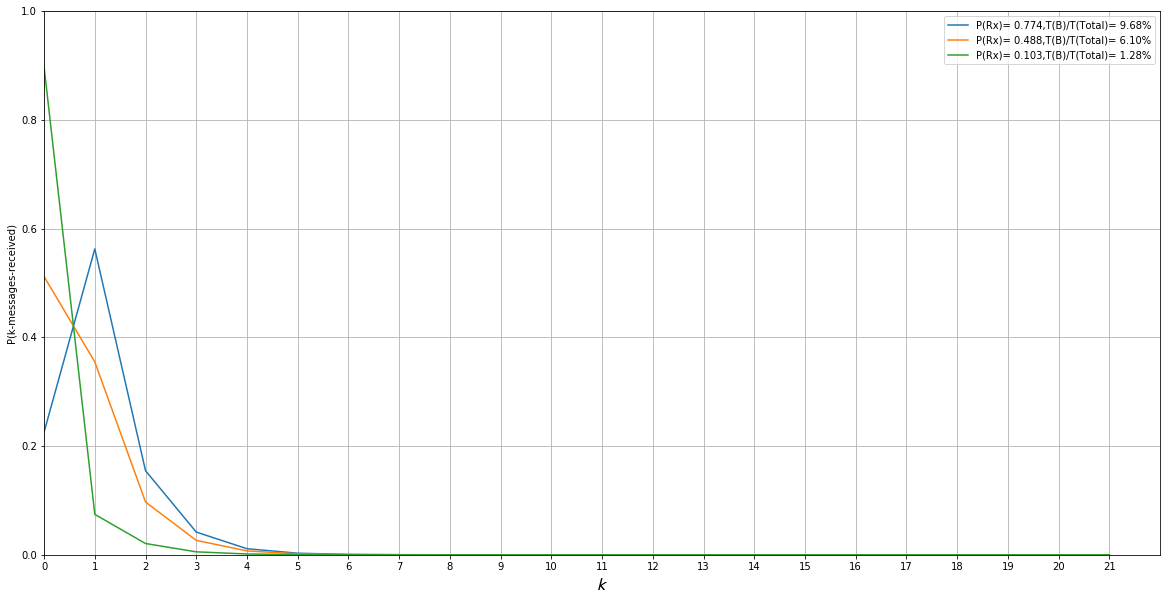

In [6]:
pt.rcParams["figure.figsize"] = (20,10)
pt.plot(range(len(hist1)),hist1,label="P(Rx)= %.3f,T(B)/T(Total)= %.2f%%"%(sum(hist1[1:]),100*Ttx*Eb1/len(raw1)))
pt.plot(range(len(hist2)),hist2,label="P(Rx)= %.3f,T(B)/T(Total)= %.2f%%"%(sum(hist2[1:]),100*Ttx*Eb2/len(raw2)))
pt.plot(range(len(hist3)),hist3,label="P(Rx)= %.3f,T(B)/T(Total)= %.2f%%"%(sum(hist3[1:]),100*Ttx*Eb3/len(raw3)))
pt.legend()
pt.axis([0,len(hist1),0,1.0])
pt.xticks(range(len(hist1)), [str(int(n)) for n in range(len(hist1))])
pt.xlabel(r'$\mathcal{k}$', fontsize = 18)
pt.ylabel(r'P(k-messages-received)')
pt.grid(True)
pt.show()